In [1]:
import torch
from torch import nn
import copy
from collections import deque
import random
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# used from https://github.com/mahakal001/reinforcement-learning/tree/master/cartpole-dqn

In [3]:
class DQN_Agent:

    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        self.loss_fn = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)

        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float()
        self.experience_replay = deque(maxlen=exp_replay_size)
        self.errors = []
        return

    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes) - 1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index + 1])
            act = nn.Tanh() if index < len(layer_sizes) - 2 else nn.Identity()
            layers += (linear, act)
        return nn.Sequential(*layers)

    def load_pretrained_model(self, model_path):
        self.q_net.load_state_dict(torch.load(model_path))

    def save_trained_model(self, model_path="cartpole-dqn.pth"):
        torch.save(self.q_net.state_dict(), model_path)

    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float())
        Q, A = torch.max(Qp, axis=0)
        A = A if torch.rand(1, ).item() > epsilon else torch.randint(0, action_space_len, (1,))
        return A

    def get_q_next(self, state):
        with torch.no_grad():
            # torch.no_grad here is confusing
            # we don't want the predicition on the comp graph? just the original?
            # we just want the gradient of the TD error computation?
            qp = self.target_net(state)
        q, _ = torch.max(qp, axis=1)
        return q

    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    def sample_from_experience(self, sample_size):
        if len(self.experience_replay) < sample_size:
            # if the size of memory is smaller than sample size, return the smaller.
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()
        return s, a, rn, sn

    def train(self, batch_size):
        # the sample is series of torch tensors to vectorize computation
        s, a, rn, sn = self.sample_from_experience(sample_size=batch_size)
        if self.network_sync_counter == self.network_sync_freq:
            # load_state_dict saves the network from dictionary
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0

        # predict expected return of current state using main network
        qp = self.q_net(s)
        # max returns a tuple (indices, values), just want the indices
        pred_return, _ = torch.max(qp, axis=1)

        # get target return using target network
        q_next = self.get_q_next(sn)
        target_return = rn + self.gamma * q_next

        loss = self.loss_fn(pred_return, target_return)
        # loss = torch.clamp(loss, min=-1, max=1)
        self.optimizer.zero_grad()
        #retain_back saves the computation graph for future use, helpful for networks with multiple outputs
        # https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
        loss.backward(retain_graph=True) # this indeed helps it learn
        self.optimizer.step()

        self.network_sync_counter += 1
        return loss.item()

In [4]:

env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed=0, layer_sizes=[input_dim, 128, output_dim], lr=1e-3, sync_freq=5,
                  exp_replay_size=exp_replay_size)
# agent = DQN_Agent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-3, sync_freq=5,
#                   exp_replay_size=exp_replay_size)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
episodes = 10000
epsilon = 1

# initiliaze experiance replay
# index = 0
# for i in range(exp_replay_size):
#     obs = env.reset()
#     done = False
#     while not done:
#         A = agent.get_action(obs, env.action_space.n, epsilon=1)
#         obs_next, reward, done, _ = env.step(A.item())
#         agent.collect_experience([obs, A.item(), reward, obs_next])
#         obs = obs_next
#         index += 1
#         if index > exp_replay_size:
#             break

index = 0

num_updates = 0
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > exp_replay_size/2:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=32)
                num_updates += 1
                losses += loss
                
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    losses_list.append(losses) 
    reward_list.append(rew)
    episode_len_list.append(ep_len)
    epsilon_list.append(epsilon)

print("Finished")
print(f'updates: {num_updates}')
# agent.save_trained_model("cartpole-dqn.pth")

100%|█████████████████████████████████████████████████| 10000/10000 [03:46<00:00, 44.12it/s]

Finished
updates: 35584


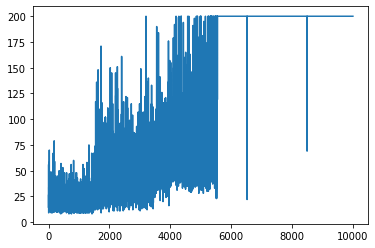

In [5]:
plt.plot(reward_list)

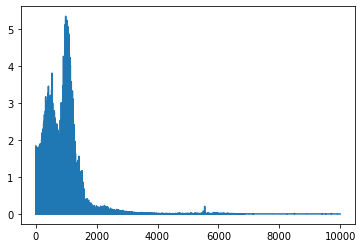

In [6]:
plt.plot(losses_list)

In [7]:
env = gym.make('CartPole-v0')
# env = gym.wrappers.Monitor(env, "record_dir", force='True')

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256

reward_arr = []
for i in tqdm(range(100)):
    obs, done, rew = env.reset(), False, 0
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=0)
        obs, reward, done, info = env.step(A.item())
        rew += reward
        # sleep(0.01)
        # env.render()

    reward_arr.append(rew)
print("average reward per episode :", sum(reward_arr) / len(reward_arr))

100%|█████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.25it/s]

average reward per episode : 200.0


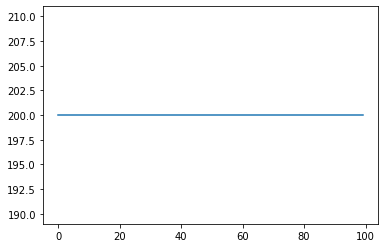

In [8]:
plt.plot(reward_arr)

In [9]:
x = torch.rand((10,2))

In [10]:
print(x)

tensor([[0.0635, 0.2269],
        [0.2954, 0.7271],
        [0.4395, 0.8771],
        [0.9966, 0.2516],
        [0.9516, 0.0776],
        [0.2055, 0.6434],
        [0.7430, 0.6897],
        [0.8237, 0.0098],
        [0.5461, 0.2000],
        [0.5270, 0.0681]])


In [11]:
acts = torch.zeros(10,dtype=torch.int64)
num_acts = 2
mask = torch.BoolTensor(10,2)
acts[[4,6,7]] = 1
mask[:,:] = False
for i in range(10):
    mask[i,acts[i]] = True
print(mask)

tensor([[ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [False,  True],
        [ True, False],
        [False,  True],
        [False,  True],
        [ True, False],
        [ True, False]])


In [12]:

acts

tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 0])

In [13]:
b = x.masked_select(mask)
b

tensor([0.0635, 0.2954, 0.4395, 0.9966, 0.0776, 0.2055, 0.6897, 0.0098, 0.5461,
        0.5270])

In [14]:
x

tensor([[0.0635, 0.2269],
        [0.2954, 0.7271],
        [0.4395, 0.8771],
        [0.9966, 0.2516],
        [0.9516, 0.0776],
        [0.2055, 0.6434],
        [0.7430, 0.6897],
        [0.8237, 0.0098],
        [0.5461, 0.2000],
        [0.5270, 0.0681]])

In [15]:
a = torch.stack([acts,acts])
print(a)

tensor([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0]])


In [16]:
actions = x.gather(1, a.T)[:,0]
print(actions)

tensor([0.0635, 0.2954, 0.4395, 0.9966, 0.0776, 0.2055, 0.6897, 0.0098, 0.5461,
        0.5270])


In [17]:
t = torch.tensor([[1, 2], [3, 4]])
print(t)
torch.gather(t, 1, torch.tensor([[0, 0], [1, 0]]))

tensor([[1, 2],
        [3, 4]])


tensor([[1, 1],
        [4, 3]])

In [18]:
a = torch.randn(5,2)
print(a)

tensor([[-2.0897,  0.3106],
        [-1.1184,  0.3406],
        [ 0.4276,  0.2279],
        [ 0.4633, -0.1951],
        [ 2.4168,  1.6889]])


In [19]:
b,_ = torch.max(a, 1)
print(b)

tensor([0.3106, 0.3406, 0.4276, 0.4633, 2.4168])


In [20]:
b

tensor([0.3106, 0.3406, 0.4276, 0.4633, 2.4168])

In [24]:
a = deque(maxlen=10)
print(a)

deque([], maxlen=10)
